In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras

from keras.utils import normalize
from keras.metrics import MeanIoU

# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
print(tf.__version__)
import tensorflow.image as tfi

# Data
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.chdir(r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset")

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras

from keras.utils import normalize
from keras.metrics import MeanIoU

# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
print(tf.__version__)
import tensorflow.image as tfi

# Data
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt







2.10.1
2.10.1


In [2]:
import os
import cv2
import numpy as np
from glob import glob

def preprocess_images_and_masks(image_paths, mask_paths):
    images = [cv2.imread(img) for img in image_paths]
    masks = [cv2.imread(mask, cv2.IMREAD_GRAYSCALE) for mask in mask_paths]
    desired_size = (128, 128)
    images = [cv2.resize(image, desired_size) for image in images]
    masks = [cv2.resize(mask, desired_size, interpolation=cv2.INTER_NEAREST) for mask in masks]
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
    images = [image / 255.0 for image in images]
    masks = [mask / 255.0 for mask in masks]
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

# Define the path to the parent directory containing images and masks folders
path = r'C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset'

# Get the paths to image and mask files using glob
image_paths = sorted(glob(os.path.join(path, "all_images", "*.png")))
mask_paths = sorted(glob(os.path.join(path, "all_masks", "*.png")))

# Preprocess the images and masks
images, masks = preprocess_images_and_masks(image_paths, mask_paths)
masks = np.expand_dims(masks, axis=-1)  # Adding an extra dimension for compatibility

# Check the dimensions of the images and masks arrays
if len(images) == 0 or len(masks) == 0:
    print("Error: Images or masks array is empty")
elif len(images) != len(masks):
    print("Error: Mismatch in number of images and masks")
else:
    # Shuffle the images and masks together
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    masks = masks[indices]

    # Calculate the number of images in each split
    num_images = len(images)
    num_train = int(0.90 * num_images)
    num_val = int(0.075 * num_images)
    num_test = num_images - num_train - num_val
    
    # Split the images and masks into training, validation, and test sets
    X_train = images[:num_train]
    y_train = masks[:num_train]
    X_val = images[num_train:num_train+num_val]
    y_val = masks[num_train:num_train+num_val]
    X_test = images[num_train+num_val:]
    y_test = masks[num_train+num_val:]

    print(f"Train: \t{len(X_train)} - {len(y_train)}")
    print(f"Validation: \t{len(X_val)} - {len(y_val)}")
    print(f"Test: \t{len(X_test)} - {len(y_test)}")


Train: 	582 - 582
Validation: 	48 - 48
Test: 	17 - 17


In [ ]:
'''import albumentations as A

# Define augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=35, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
])

# Augment each image and mask in X_train and y_train
X_train_augmented = []
y_train_augmented = []

for idx in range(len(X_train)):
    image = X_train[idx]
    mask = y_train[idx]

    # Apply augmentation pipeline
    augmented = transform(image=image, mask=mask)
    image_up = augmented['image']
    mask_up = augmented['mask']

    X_train_augmented.append(image_up)
    y_train_augmented.append(mask_up)

# Convert lists to numpy arrays
X_train = np.array(X_train_augmented)
y_train = np.array(y_train_augmented)

# Resize augmented images and masks if necessary
# X_train_augmented = [cv2.resize(img, target_size) for img in X_train_augmented]
# y_train_augmented = [cv2.resize(mask, target_size) for mask in y_train_augmented]

# Print shapes after augmentation
print("Train images shape after augmentation:", X_train.shape)
print("Train masks shape after augmentation:", y_train.shape)

# Adjust threshold and convert masks
threshold = 0.5
y_train = (y_train > threshold).astype(int)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled
'''

In [ ]:
print(f"Train: \t{len(X_train)} - {len(y_train)}")
print(f"Test: \t{len(X_test)} - {len(y_test)}")
print(f"val: \t{len(X_val)} - {len(y_val)}")

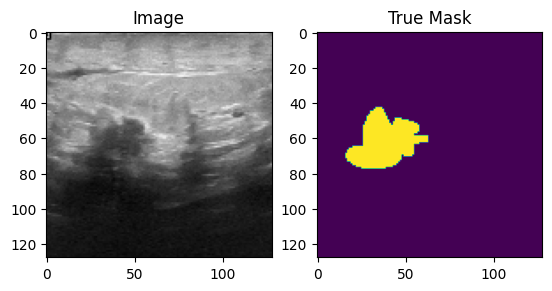

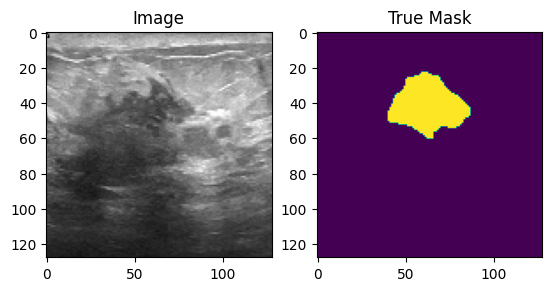

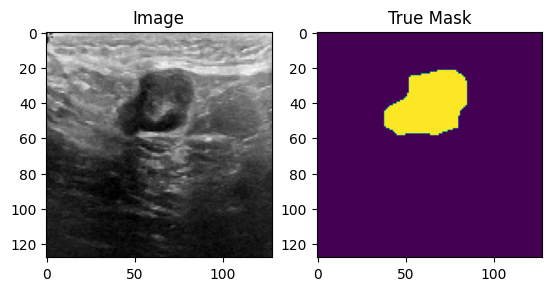

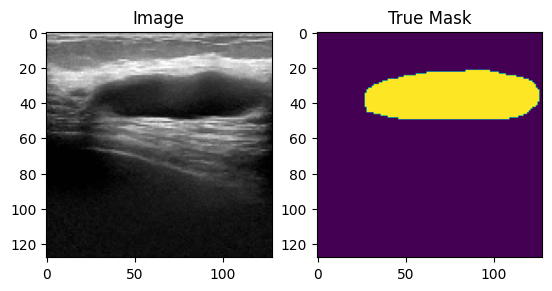

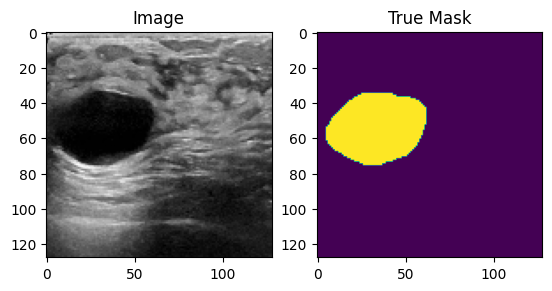

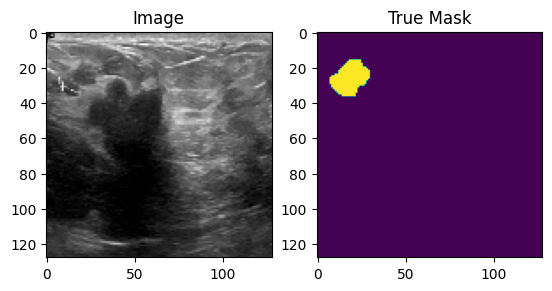

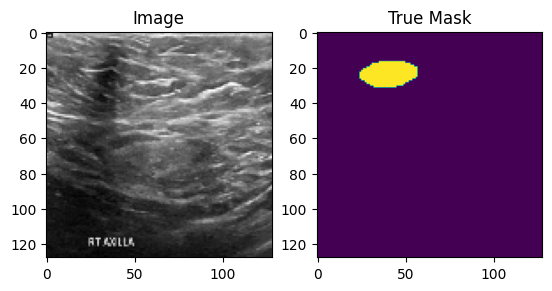

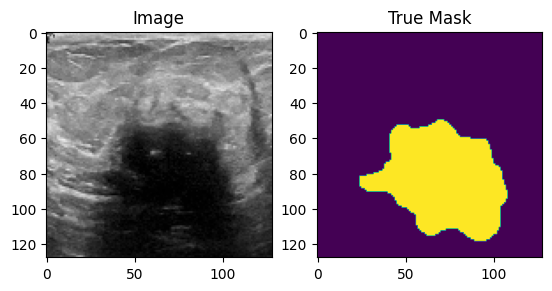

In [3]:
for i in range(8):
    image = X_val[i]
    mask = y_val[i]
    
    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.optimizers import Adam

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


#DICE METRIC
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

#IOU METRIC
def iou_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1.) / (union + 1.)


def f1_score(y_true, y_pred):
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score


def iou_loss(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou  # Minimize (1 - IoU) as loss














In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (128, 128, 3)
    model = build_vgg19_unet(input_shape)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=iou_loss, metrics=['accuracy', iou_metric, dice_metric, f1_score, recall, precision, specificity])
    model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [7]:

import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd

# Cast data types
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Cast masks to tf.int32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Config Training
BATCH_SIZE = 2
SPE = len(X_train)//BATCH_SIZE

# Define the filepath to save the best model
filepath = r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\best_model_iou.h5"

# Define callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_metric', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='iou_metric', patience=10, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Train the model
results = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, 
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Convert history to DataFrame
history_df = pd.DataFrame(results.history)

# Save the DataFrame to a CSV file in the specified path
save_path = r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\training_results.csv"
history_df.to_csv(save_path, index=False)



Epoch 1/200
291/291 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.8523 - iou_metric: 0.2606 - dice_metric: 0.3910 - f1_score: 0.4123 - recall: 0.6699 - precision: 0.3667 - specificity: 0.8811
Epoch 1: val_iou_metric improved from -inf to 0.20450, saving model to C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\best_model_iou.h5
291/291 [==============================] - 14s 36ms/step - loss: 0.7394 - accuracy: 0.8523 - iou_metric: 0.2606 - dice_metric: 0.3910 - f1_score: 0.4123 - recall: 0.6699 - precision: 0.3667 - specificity: 0.8811 - val_loss: 0.7955 - val_accuracy: 0.7526 - val_iou_metric: 0.2045 - val_dice_metric: 0.3229 - val_f1_score: 0.3238 - val_recall: 0.8611 - val_precision: 0.2242 - val_specificity: 0.7521 - lr: 0.0010
Epoch 2/200
291/291 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.9062 - iou_metric: 0.3506 - dice_metric: 0.4960 - f1_score: 0.5010 - recall: 0.6233 - precision: 0.

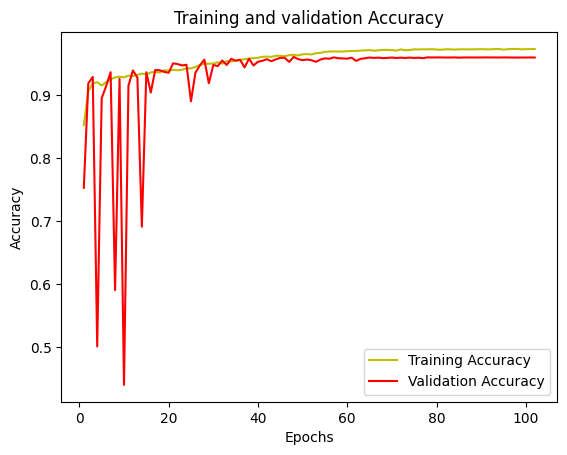

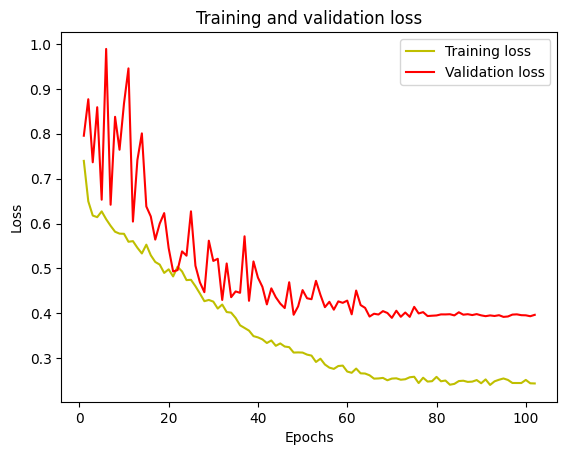

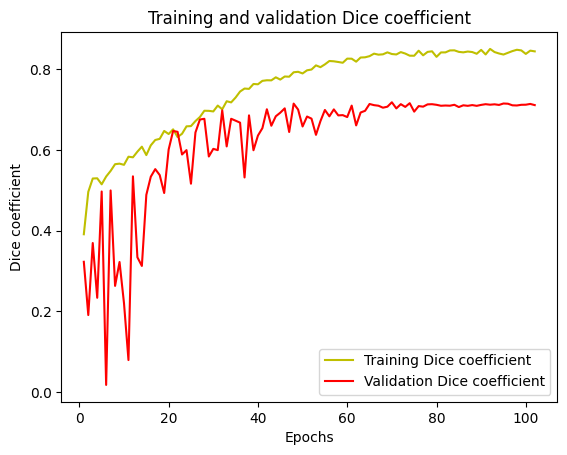

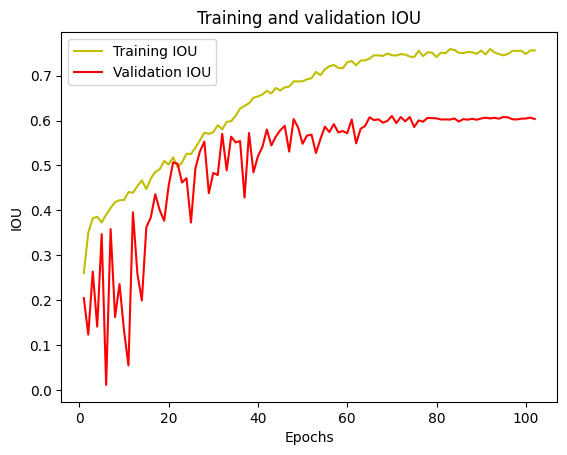

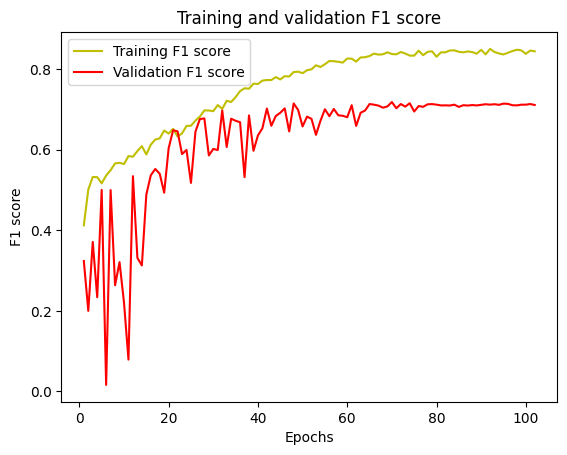

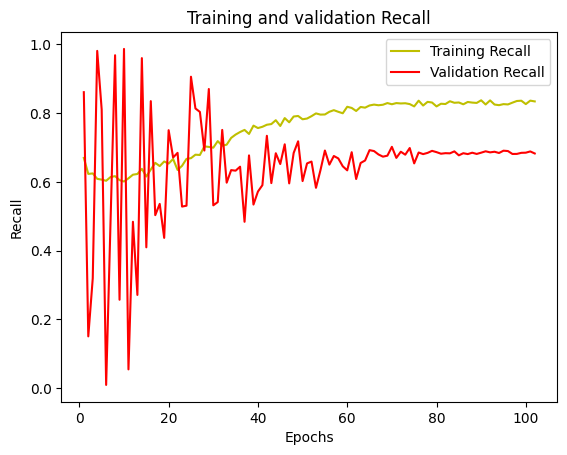

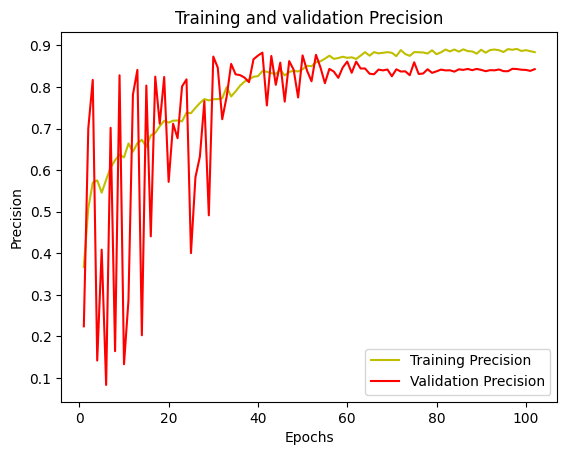

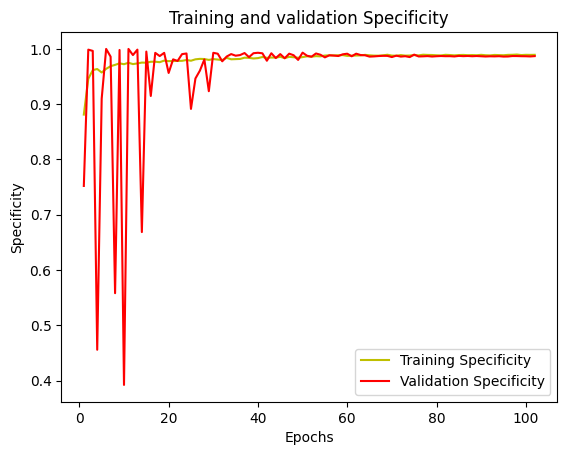

In [8]:
import matplotlib.pyplot as plt
import os

# Path to store the figures
figures_dir = r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\figures_metrics_VGG19"

# Ensure the directory exists, create if not
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Rest of your code remains unchanged
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
iou = results.history['iou_metric']
val_iou = results.history['val_iou_metric']
f1 = results.history['f1_score']
val_f1 = results.history['val_f1_score']
recall = results.history['recall']
val_recall = results.history['val_recall']
precision = results.history['precision']
val_precision = results.history['val_precision']
specificity = results.history['specificity']
val_specificity = results.history['val_specificity']
dice_metric = results.history['dice_metric']
val_dice_metric = results.history['val_dice_metric']

epochs = range(1, len(loss) + 1)

# Plot acc
plt.figure()
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'accuracy_plot.png'), dpi=800)
plt.show()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'loss_plot.png'), dpi=800)
plt.show()

# Plot dice
plt.figure()
plt.plot(epochs, dice_metric, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_dice_metric, 'r', label='Validation Dice coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice coefficient')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'dice_plot.png'), dpi=800)
plt.show()

# Plot IOU
plt.figure()
plt.plot(epochs, iou, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'iou_plot.png'), dpi=800)
plt.show()

# Plot F1 score
plt.figure()
plt.plot(epochs, f1, 'y', label='Training F1 score')
plt.plot(epochs, val_f1, 'r', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'f1_score_plot.png'), dpi=800)
plt.show()

# Plot Recall
plt.figure()
plt.plot(epochs, recall, 'y', label='Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'recall_plot.png'), dpi=800)
plt.show()

# Plot Precision
plt.figure()
plt.plot(epochs, precision, 'y', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'precision_plot.png'), dpi=800)
plt.show()

# Plot Specificity
plt.figure()
plt.plot(epochs, specificity, 'y', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r', label='Validation Specificity')
plt.title('Training and validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'specificity_plot.png'), dpi=800)
plt.show()



In [9]:

'''done code for calculate test prediction'''

import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define custom metrics and loss functions
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

def iou_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1.) / (union + 1.)

def f1_score(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def iou_loss(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou  # Minimize (1 - IoU) as loss

# Load the model
history = load_model('best_model_iou.h5', custom_objects={'iou_loss': iou_loss, 'recall': recall, 'precision': precision, 'specificity': specificity, 'dice_metric': dice_metric, 'iou_metric': iou_metric, 'f1_score': f1_score})

# Make predictions on the test images in batches
batch_size = 4
num_samples = X_test.shape[0]
predictions = []

for i in range(0, num_samples, batch_size):
    batch_predictions = model.predict(X_test[i:i+batch_size])
    predictions.append(batch_predictions)

# Concatenate predictions from all batches
predictions = np.concatenate(predictions, axis=0)

# Remove the last dimension from predictions
predictions = predictions.squeeze(axis=-1)

# Threshold predictions to obtain binary values
predictions_binary = np.where(predictions > 0.5, 1, 0)

# Compute the mean IoU metric on the test set
iou_score = iou_metric(y_test, predictions_binary)

# Compute the Dice coefficient on the test set
dice_coef_score = dice_metric(y_test, predictions_binary)

# Compute the accuracy on the test set
accuracy = accuracy_score(y_test.flatten(), predictions_binary.flatten())

# Compute the precision and recall on the test set
precision = Precision()
precision.update_state(y_test, predictions)

recall = Recall()
recall.update_state(y_test, predictions)

# Compute the F1 score on the test set
f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())

# Create a dictionary for the metrics
metrics_dict = {
    'IoU Score': [iou_score],
    'Dice Coefficient': [dice_coef_score],
    'Accuracy': [accuracy],
    'Precision': [precision.result()],
    'Recall': [recall.result()],
    'F1 Score': [f1_score]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Save the DataFrame to a CSV file
metrics_df.to_csv(r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\vgg_testing_metrics.csv", index=False)

1/1 [==============================] - 1s 542ms/step


IndexError: index 17 is out of bounds for axis 0 with size 17

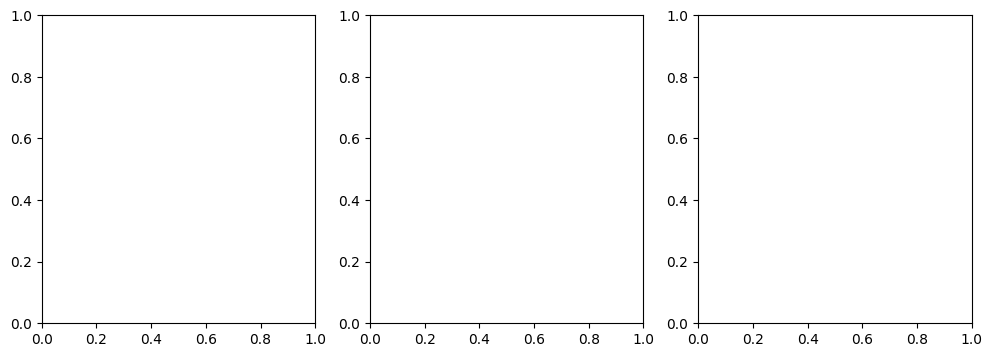

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Path to store the images
result_folder = r"C:\Users\pro\anaconda3\BUS\Breast Tumor Segmentations Models\VGG19  Model orginal\Dataset\vgg19-segmentation-result"

# Ensure the directory exists, create if not
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# Save training results to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(result_folder, 'training_history.csv'), index=False)

# Save 20 images with original masks and predicted masks
n_samples = 30
for i in range(n_samples):
    # Plot the original image, mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_test[i])
    axes[0].set_title('Original Image')
    axes[1].imshow(y_test[i], cmap='gray')
    axes[1].set_title('Original Mask')
    axes[2].imshow(predictions_binary[i], cmap='gray')
    axes[2].set_title('Predicted Mask')

    # Save the figure
    plt.savefig(os.path.join(result_folder, f'image_{i+1}.png'), dpi=800)
    plt.close()

    # Optionally, you can save the images with PIL if needed
    # original_image = Image.fromarray((X_test[i] * 255).astype(np.uint8))
    # original_image.save(os.path.join(result_folder, f'original_image_{i+1}.png'))
    # mask_image = Image.fromarray((y_test[i] * 255).astype(np.uint8))
    # mask_image.save(os.path.join(result_folder, f'original_mask_{i+1}.png'))
    # predicted_mask_image = Image.fromarray((predictions_binary[i] * 255).astype(np.uint8))
    # predicted_mask_image.save(os.path.join(result_folder, f'predicted_mask_{i+1}.png'))
